# MRI Brain Tumour Classifier, based on Google's MobilenetV2 Model
References:
- https://blog.research.google/2019/11/introducing-next-generation-on-device.html
- https://arxiv.org/abs/1801.04381
- https://keras.io/api/applications/mobilenet/#mobilenetv2-function
- https://www.kaggle.com/code/slavenjabuka/cnn-98-84-mobilenet-v2-99-35
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.tensorflow.org/tutorials/load_data/images

In [1]:
# Import required functions and libraries
from utils import *
from sklearn.model_selection import StratifiedKFold, KFold
import json

# Dataset Preparations

Found 480 files belonging to 4 classes.
Using 384 files for training.
Using 96 files for validation.

Training Dataset Preview


2024-07-08 16:20:20.606359: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-08 16:20:20.606393: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-08 16:20:20.606404: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-08 16:20:20.606615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-08 16:20:20.606636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-08 16:20:21.054998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


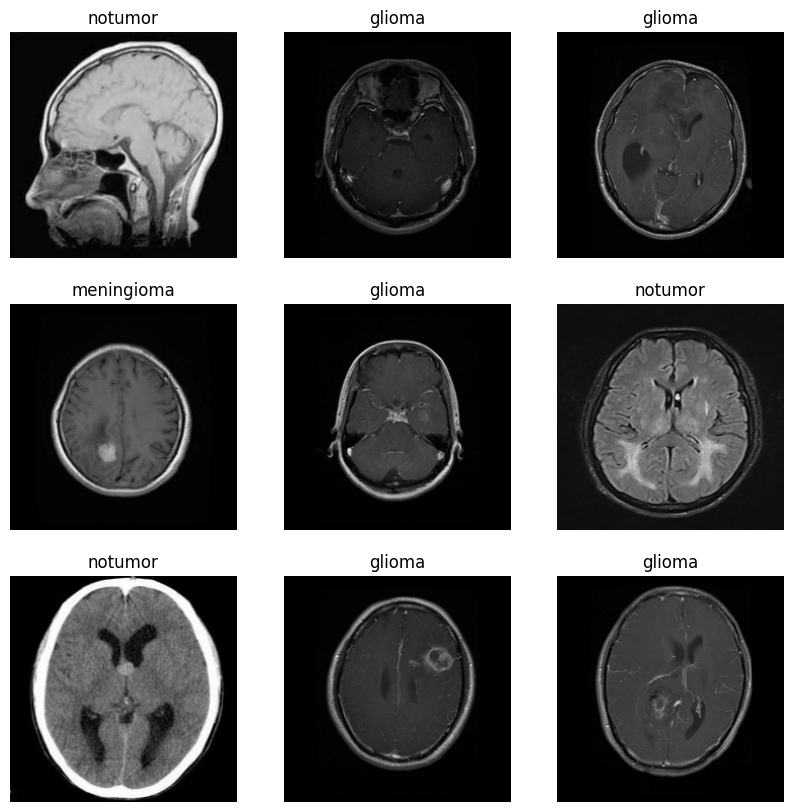

Validation Dataset Preview


2024-07-08 16:20:21.471379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


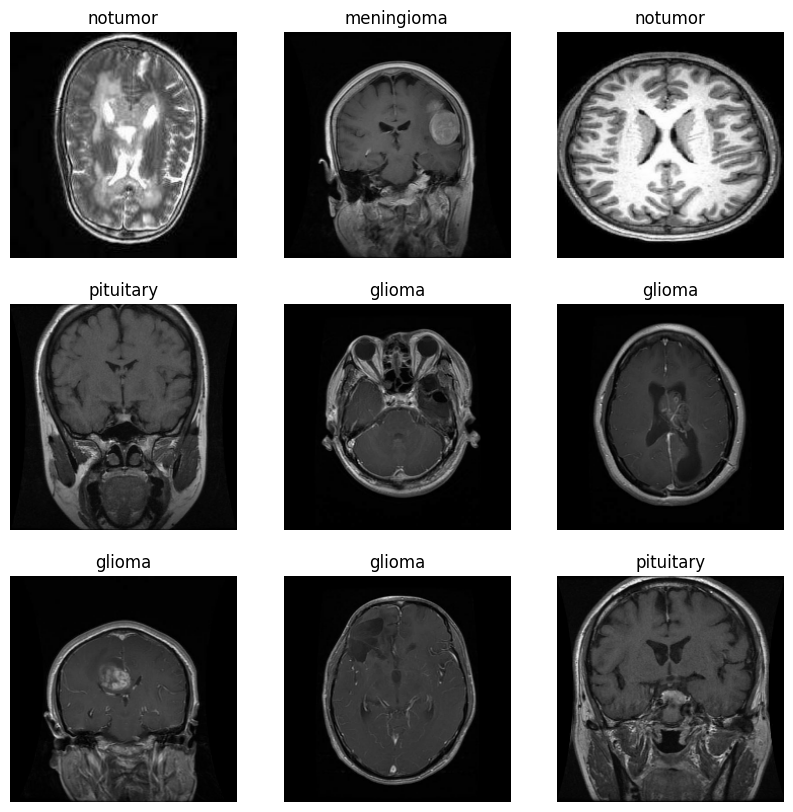

In [2]:
# Parameters
img_batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width) # MobilenetV2 requires 224x224 input images
img_shape = img_size + (3,)

# Get training and validation datasets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="both",
  shuffle=True,
  seed=RANDOM_STATE,
  image_size=img_size,
  batch_size=img_batch_size)

# Get class names
class_names = train_ds.class_names
# class_names = val_ds.class_names

# Enable buffered prefetching to overlap data preprocessing and model execution during training, to speed up access to dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Preview datasets
print("\nTraining Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

print("Validation Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()    

## Build the initial base model
Create a base model, by attaching a new classification head on top of the MobileNetV2 model for transfer learning. The top model added onto the base model is intentionally kept as simple as possible to prevent overfitting, and to maximise the usage of features extracted by the base model.

In [37]:
# Input layer
inputs = keras.Input(shape=img_shape)

# Preprocessing layers (data augmetation)
x = tf.keras.layers.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)

# Base model layer, ensure that the model is running in inference mode
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model.output

# Processing layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Training

In [4]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64)

Epoch 1/50


2024-07-08 16:21:23.074908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.4389 - loss: 1.2705 - val_accuracy: 0.7500 - val_loss: 0.8771
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7228 - loss: 0.8297 - val_accuracy: 0.6875 - val_loss: 0.7360
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7308 - loss: 0.7243 - val_accuracy: 0.7604 - val_loss: 0.6471
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7303 - loss: 0.6532 - val_accuracy: 0.8333 - val_loss: 0.5872
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7969 - loss: 0.5741 - val_accuracy: 0.8333 - val_loss: 0.5643
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7971 - loss: 0.5452 - val_accuracy: 0.8333 - val_loss: 0.5276
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8136 - loss: 0.4953 - val_accuracy: 0.8542 - val_loss: 0.5002
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7839 - loss: 0.5042 - val_accuracy: 0.8750 - val_loss: 0

## Visualise Training

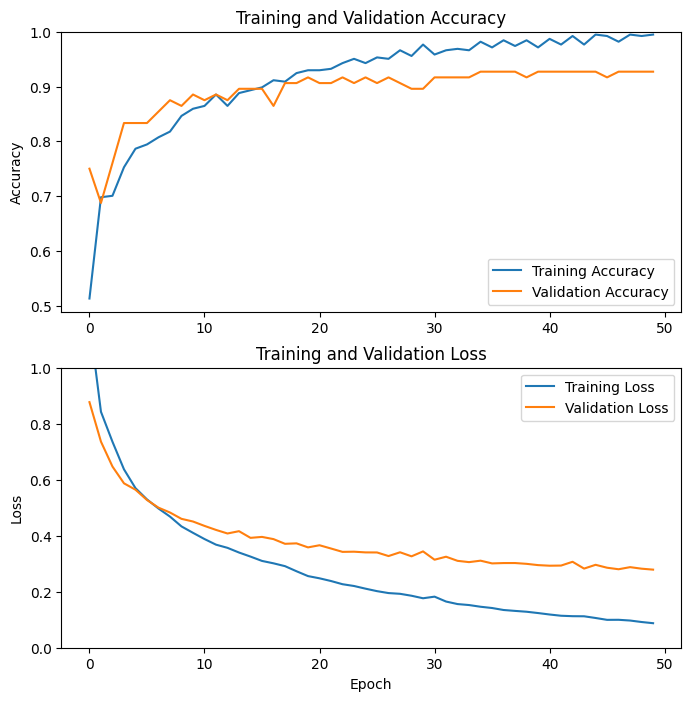

Training Results:
~Accuracy~
Max (best) accuracy: 0.9947916865348816 at epoch 45
Min (worst) accuracy: 0.5130208134651184 at epoch 1
Median accuracy: 0.9505208134651184
Mean accuracy: 0.9130729150772094

~Loss~
Min (best) loss: 0.08757705241441727 at epoch 50
Max (worst) loss: 1.167099118232727 at epoch 1
Median loss: 0.2064596563577652
Mean loss: 0.28199686110019684

~Final Training Performance~
Accuracy: 0.9973958134651184, Loss: 0.08279649168252945

Validation Results:
~Accuracy~
Max (best) accuracy: 0.9270833134651184 at epoch 35
Min (worst) accuracy: 0.6875 at epoch 2
Median accuracy: 0.90625
Mean accuracy: 0.8929166626930237

~Loss~
Min (best) loss: 0.27886947989463806 at epoch 50
Max (worst) loss: 0.8770880699157715 at epoch 1
Median loss: 0.34160016477108
Mean loss: 0.38340731263160704

~Final Validation Performance~
Accuracy: 0.9270833134651184, Loss: 0.27886947989463806


In [5]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(val_ds, verbose=0)))

## Model Performance

In [6]:
print("~Training Metrics~")
get_model_metrics(train_ds, model)

print("\n~Validation Metrics~")
get_model_metrics(val_ds, model)

~Training Metrics~


2024-07-08 16:22:39.618276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy: 0.9973958333333334
Precision: 0.9974489795918368
Recall: 0.9974226804123711
F1 Score: 0.997422611930384
Matthews Correlation Coefficient (MCC): 0.9965364129220377
Cohen's Kappa: 0.9965274009766685
Hamming Loss: 0.0026041666666666665

Confusion Matrix:
 [[96  0  0  1]
 [ 0 93  0  0]
 [ 0  0 97  0]
 [ 0  0  0 97]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        97
           3       0.99      1.00      0.99        97

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



~Validation Metrics~
Accuracy: 0.9270833333333334
Precision: 0.9273272017837236
Recall: 0.928743961352657
F1 Score: 0.9278489518789381
Matthews Correlation Coefficient (MCC): 0.9027959711030173
Cohen's Kappa: 0.902

2024-07-08 16:22:39.912505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# K-Fold Cross-Validation to validate model performance

In [8]:
""" K-Fold Cross-Validation """
# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=img_size,
    batch_size=img_batch_size
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1
    
print("\nStratified K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in skf.split(images, labels):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_skf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

Found 480 files belonging to 4 classes.


2024-07-08 16:24:27.187762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 1.0, Loss: 0.01602288894355297
~Validation Dataset~
Accuracy: 0.8854166865348816, Loss: 0.26495152711868286

Fold Index 1
~Training Dataset~
Accuracy: 1.0, Loss: 0.008030427619814873
~Validation Dataset~
Accuracy: 0.9895833134651184, Loss: 0.05010903999209404

Fold Index 2
~Training Dataset~
Accuracy: 1.0, Loss: 0.0025432498659938574
~Validation Dataset~
Accuracy: 1.0, Loss: 0.009226281195878983

Fold Index 3
~Training Dataset~
Accuracy: 1.0, Loss: 0.0006967894150875509
~Validation Dataset~
Accuracy: 1.0, Loss: 0.004404996521770954

Fold Index 4
~Training Dataset~
Accuracy: 1.0, Loss: 0.00020227320783305913
~Validation Dataset~
Accuracy: 1.0, Loss: 0.002828056225553155


Stratified K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 1.0, Loss: 9.68422755249776e-05
~Validation Dataset~
Accuracy: 1.0, Loss: 0.0010271233040839434

Fold Index 1
~Training Dataset~
Accuracy: 1.0, Loss: 3.093706982326694e-05
~Vali

In [10]:
print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

print("\nStratified K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_skf_results]
train_losses = [result['train_loss'] for result in list_skf_results]
val_accuracies = [result['val_accuracy'] for result in list_skf_results]
val_losses = [result['val_loss'] for result in list_skf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 1.0,
        "min": 1.0,
        "median": 1.0,
        "mean": 1.0
    },
    "Training Loss": {
        "max": 0.01602288894355297,
        "min": 0.00020227320783305913,
        "median": 0.0025432498659938574,
        "mean": 0.005499125810456462
    },
    "Validation Accuracy": {
        "max": 1.0,
        "min": 0.8854166865348816,
        "median": 1.0,
        "mean": 0.975
    },
    "Validation Loss": {
        "max": 0.26495152711868286,
        "min": 0.002828056225553155,
        "median": 0.009226281195878983,
        "mean": 0.066303980210796
    }
}

Stratified K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 1.0,
        "min": 1.0,
        "median": 1.0,
        "mean": 1.0
    },
    "Training Loss": {
        "max": 9.68422755249776e-05,
        "min": 2.1985322291584453e-06,
        "median": 1.4032678336661775e-05,
        "mean": 2.956647126666212e-05
    },
 

The model based on MobileNetV2 returns optimal performance consistently throughout, given its simple classification head and hyperparameters. We will use this initial model as the final model for Transfer Learning with MobileNetV2, without further fine-tuning of hyper-parameters as doing so would result in overfitting and poorer performance, as demonstrated in the subsequent sections. 

In [ ]:
# Export model
model.save(MODEL_V2_FILE)

# Load the trained model
# model = keras.models.load_model(MODEL_V2_FILE)

## Hyperparameter Fine-Tuning
Subsequently, we will try to further fine-tune the model by finding the optimal *learning rate* using Keras Tuner, and the Learning Rate Scheduler.

### Keras Tuner

In [ ]:
import keras_tuner as kt

""" Hyperparameter Tuning"""
def build_model(hp):
  
  # Input layer
  inputs = keras.Input(shape=img_shape)

  # Preprocessing layers (data augmetation)
  x = tf.keras.layers.RandomFlip('horizontal')(inputs)
  x = tf.keras.layers.RandomRotation(0.2)(x)
  x = tf.keras.layers.RandomZoom(0.2)(x)

  # Base model layer, ensure that the model is running in inference mode
  base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
  base_model.trainable = False
  x = base_model.output

  # Processing layers
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(len(class_names), activation='softmax')(x)

  model = keras.Model(inputs=base_model.input, outputs=x)

  # Compile model with hyperparameters
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log"), beta_1=0.9, beta_2=0.99),
                metrics=['accuracy'])
  
  return model

# Test if the model builds successfully
build_model(kt.HyperParameters())

<Functional name=functional_5, built=True>

In [ ]:
# Define the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=50,
    				 directory="hyperparameter-search",
    				 project_name="brain-tumor-classification",
)

# Search for the best hyperparameters
tuner.search(train_ds, epochs=50, validation_data=val_ds)

Trial 90 Complete [00h 01m 24s]
val_accuracy: 0.8125

Best val_accuracy So Far: 0.875
Total elapsed time: 05h 53m 21s


In [ ]:
# Get the optimal hyperparameters after the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("~Optimal Hyperparameters~")
print(f"Learning Rate: {best_hps.get('lr')}")

~Optimal Hyperparameters~
Learning Rate: 0.0065117874801730825


Keras Tuner returns an optimal learning rate of `0.0065117874801730825`

### Learning Rate Scheduler

In [38]:
# Input layer
inputs = keras.Input(shape=img_shape)

# Preprocessing layers (data augmetation)
x = tf.keras.layers.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)

# Base model layer, ensure that the model is running in inference mode
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model.output

# Processing layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[lr_scheduler])

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2631 - loss: 1.5055 - val_accuracy: 0.4062 - val_loss: 1.3049 - learning_rate: 1.0000e-04
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.4067 - loss: 1.3324 - val_accuracy: 0.5208 - val_loss: 1.2171 - learning_rate: 1.1220e-04
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.4971 - loss: 1.2193 - val_accuracy: 0.6042 - val_loss: 1.1470 - learning_rate: 1.2589e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.5462 - loss: 1.1346 - val_accuracy: 0.6667 - val_loss: 1.0747 - learning_rate: 1.4125e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5811 - loss: 1.0618 - val_accuracy: 0.6875 - val_loss: 1.0059 - learning_rate: 1.5849e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6071 - loss: 0.9971 - val_accuracy: 0.6875 - val_loss: 0.9452 - learning_rate: 1.7783e-04
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.

The optimal learning rate is 0.007079457843841381


Text(0, 0.5, 'val_loss')

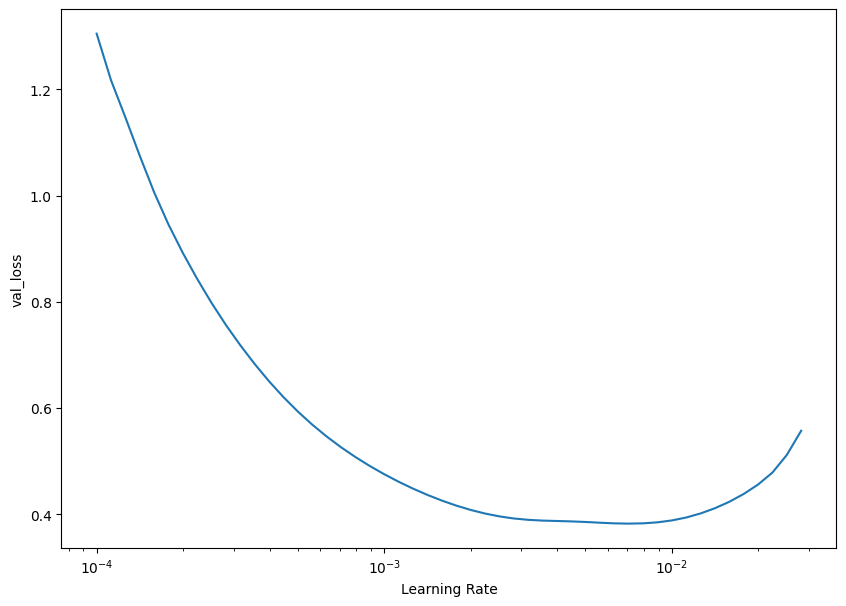

In [39]:
lrs = 1e-4 * (10 ** (np.arange(50)/20))
minimum = min(history.history['val_loss'])
index = history.history['val_loss'].index(minimum)
lr = lrs[index]
print("The optimal learning rate is", lr)

# Plot learning rate vs loss
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history.history['val_loss'])
plt.xlabel('Learning Rate')
plt.ylabel('val_loss')

Learning Rate Scheduler returns an optimal learning rate of `0.007079457843841381`

## Build the model with the fine-tuned hyperparameters

In [40]:
# Input layer
inputs = keras.Input(shape=img_shape)

# Preprocessing layers (data augmetation)
x = tf.keras.layers.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)

# Base model layer, ensure that the model is running in inference mode
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model.output

# Processing layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(len(class_names), activation='softmax')(x)

# Define optimisers for fine-tuned learning rates obtained from the keras tuner and learning rate scheduler
optimizer_kt = tf.keras.optimizers.Adam(learning_rate=0.0065117874801730825, beta_1=0.9, beta_2=0.99)
optimizer_lrs = tf.keras.optimizers.Adam(learning_rate=0.007079457843841381, beta_1=0.9, beta_2=0.99)

# Compile model with hyperparameters
model_kt = keras.Model(inputs=base_model.input, outputs=x)
model_kt.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_kt, metrics=['accuracy'])
model_lrs = keras.Model(inputs=base_model.input, outputs=x)
model_lrs.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_lrs, metrics=['accuracy'])

## Fine-Tuned Model Training

In [41]:
history_kt = model_kt.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64)
history_lrs = model_lrs.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4908 - loss: 1.1547 - val_accuracy: 0.7292 - val_loss: 0.8748
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.8031 - loss: 0.4781 - val_accuracy: 0.7500 - val_loss: 0.6343
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.8760 - loss: 0.3690 - val_accuracy: 0.7708 - val_loss: 0.5629
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.8545 - loss: 0.3665 - val_accuracy: 0.7917 - val_loss: 0.4602
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8586 - loss: 0.3464 - val_accuracy: 0.7917 - val_loss: 0.4747
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8635 - loss: 0.3235 - val_accuracy: 0.7292 - val_loss: 0.6438
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8513 - loss: 0.3849 - val_accuracy: 0.7604 - val_loss: 0.5410
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8817 - loss: 0.2821 - val_accuracy: 0.8021 

## Visualise Training of Fine-Tuned Model

### Keras Tuner

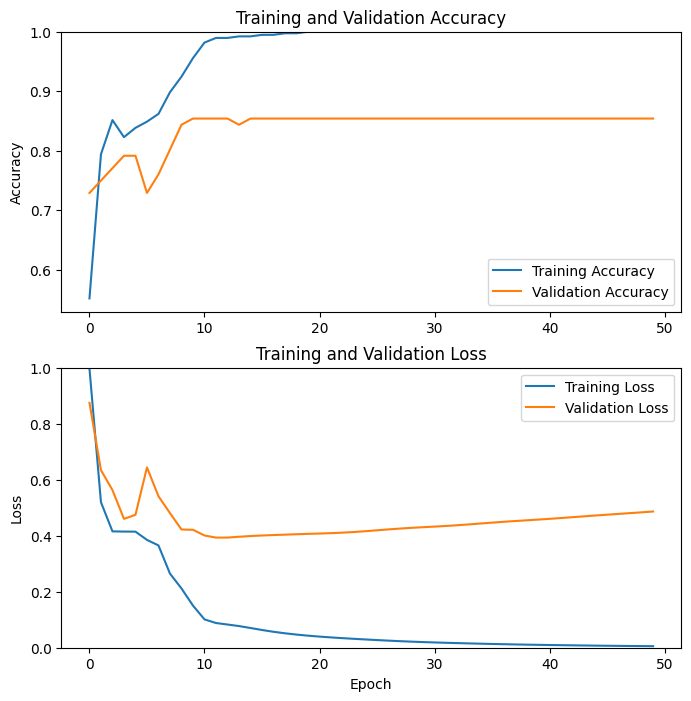

Training Results:
~Accuracy~
Max (best) accuracy: 1.0 at epoch 20
Min (worst) accuracy: 0.5520833134651184 at epoch 1
Median accuracy: 1.0
Mean accuracy: 0.9655729162693024

~Loss~
Min (best) loss: 0.005497854668647051 at epoch 50
Max (worst) loss: 0.9976491332054138 at epoch 1
Median loss: 0.02841541077941656
Mean loss: 0.10653405155055225

~Final Training Performance~
Accuracy: 1.0, Loss: 0.00030169301317073405

Validation Results:
~Accuracy~
Max (best) accuracy: 0.8541666865348816 at epoch 10
Min (worst) accuracy: 0.7291666865348816 at epoch 1
Median accuracy: 0.8541666865348816
Mean accuracy: 0.8395833504199982

~Loss~
Min (best) loss: 0.3933095932006836 at epoch 12
Max (worst) loss: 0.8747617602348328 at epoch 1
Median loss: 0.43896137177944183
Mean loss: 0.4577347880601883

~Final Validation Performance~
Accuracy: 0.8541666865348816, Loss: 0.6267992854118347


In [42]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_kt.history['accuracy'], label='Training Accuracy')
plt.plot(history_kt.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history_kt.history['loss'], label='Training Loss')
plt.plot(history_kt.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history_kt.history['accuracy']), "at epoch", history_kt.history['accuracy'].index(max(history_kt.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history_kt.history['accuracy']), "at epoch", history_kt.history['accuracy'].index(min(history_kt.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history_kt.history['accuracy']))
print("Mean accuracy:", np.mean(history_kt.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history_kt.history['loss']), "at epoch", history_kt.history['loss'].index(min(history_kt.history['loss'])) + 1)
print("Max (worst) loss:", max(history_kt.history['loss']), "at epoch", history_kt.history['loss'].index(max(history_kt.history['loss'])) + 1)
print("Median loss:", np.median(history_kt.history['loss']))
print("Mean loss:", np.mean(history_kt.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model_kt.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history_kt.history['val_accuracy']), "at epoch", history_kt.history['val_accuracy'].index(max(history_kt.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history_kt.history['val_accuracy']), "at epoch", history_kt.history['val_accuracy'].index(min(history_kt.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history_kt.history['val_accuracy']))
print("Mean accuracy:", np.mean(history_kt.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history_kt.history['val_loss']), "at epoch", history_kt.history['val_loss'].index(min(history_kt.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history_kt.history['val_loss']), "at epoch", history_kt.history['val_loss'].index(max(history_kt.history['val_loss'])) + 1)
print("Median loss:", np.median(history_kt.history['val_loss']))
print("Mean loss:", np.mean(history_kt.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model_kt.evaluate(val_ds, verbose=0)))

In [ ]:
print("~Training Metrics~")
get_model_metrics(train_ds, model_kt)

print("\n~Validation Metrics~")
get_model_metrics(val_ds, model_kt)

~Training Metrics~


2024-07-08 23:18:34.371773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Cohen's Kappa: 1.0
Hamming Loss: 0.0

Confusion Matrix:
 [[96  0  0  0]
 [ 0 96  0  0]
 [ 0  0 96  0]
 [ 0  0  0 96]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        96
           2       1.00      1.00      1.00        96
           3       1.00      1.00      1.00        96

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



~Validation Metrics~
Accuracy: 0.8541666666666666
Precision: 0.8503479853479854
Recall: 0.8541666666666666
F1 Score: 0.8510090702947846
Matthews Correlation Coefficient (MCC): 0.8063726084191944
Cohen's Kappa: 0.8055555555555556
Hamming Loss: 0.14583333333333334

Confusion Matrix:
 [[24  0  0  0]
 [ 1 16  4  3]
 [ 0  3 

2024-07-08 23:18:34.894892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Learning Rate Scheduler

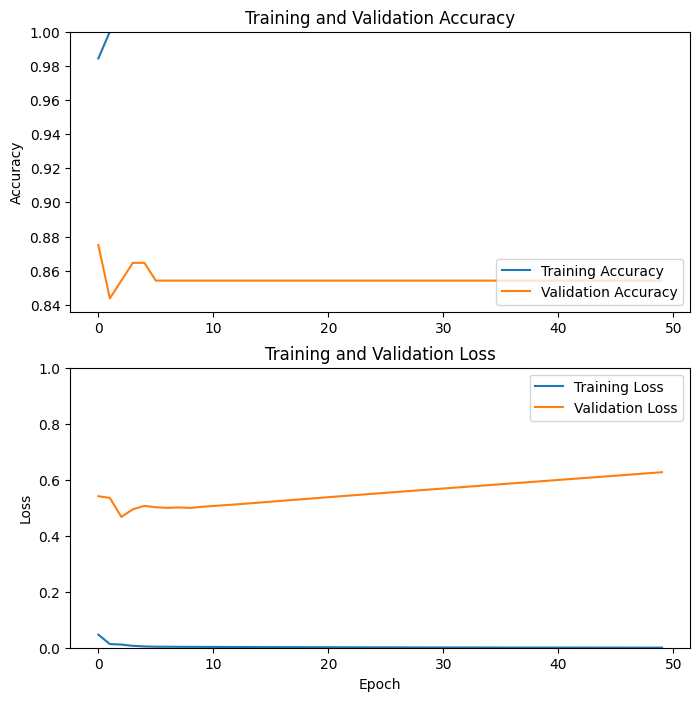

Training Results:
~Accuracy~
Max (best) accuracy: 1.0 at epoch 2
Min (worst) accuracy: 0.984375 at epoch 1
Median accuracy: 1.0
Mean accuracy: 0.9996875

~Loss~
Min (best) loss: 0.00032029167050495744 at epoch 50
Max (worst) loss: 0.04668267443776131 at epoch 1
Median loss: 0.0013054641894996166
Mean loss: 0.0029280015401309356

~Final Training Performance~
Accuracy: 1.0, Loss: 0.00030169301317073405

Validation Results:
~Accuracy~
Max (best) accuracy: 0.875 at epoch 1
Min (worst) accuracy: 0.84375 at epoch 2
Median accuracy: 0.8541666865348816
Mean accuracy: 0.8547916841506958

~Loss~
Min (best) loss: 0.4670741558074951 at epoch 3
Max (worst) loss: 0.6267992854118347 at epoch 50
Median loss: 0.5517695844173431
Mean loss: 0.5544262152910232

~Final Validation Performance~
Accuracy: 0.8541666865348816, Loss: 0.6267992854118347


In [ ]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_lrs.history['accuracy'], label='Training Accuracy')
plt.plot(history_lrs.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history_lrs.history['loss'], label='Training Loss')
plt.plot(history_lrs.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history_lrs.history['accuracy']), "at epoch", history_lrs.history['accuracy'].index(max(history_lrs.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history_lrs.history['accuracy']), "at epoch", history_lrs.history['accuracy'].index(min(history_lrs.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history_lrs.history['accuracy']))
print("Mean accuracy:", np.mean(history_lrs.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history_lrs.history['loss']), "at epoch", history_lrs.history['loss'].index(min(history_lrs.history['loss'])) + 1)
print("Max (worst) loss:", max(history_lrs.history['loss']), "at epoch", history_lrs.history['loss'].index(max(history_lrs.history['loss'])) + 1)
print("Median loss:", np.median(history_lrs.history['loss']))
print("Mean loss:", np.mean(history_lrs.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model_lrs.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history_lrs.history['val_accuracy']), "at epoch", history_lrs.history['val_accuracy'].index(max(history_lrs.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history_lrs.history['val_accuracy']), "at epoch", history_lrs.history['val_accuracy'].index(min(history_lrs.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history_lrs.history['val_accuracy']))
print("Mean accuracy:", np.mean(history_lrs.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history_lrs.history['val_loss']), "at epoch", history_lrs.history['val_loss'].index(min(history_lrs.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history_lrs.history['val_loss']), "at epoch", history_lrs.history['val_loss'].index(max(history_lrs.history['val_loss'])) + 1)
print("Median loss:", np.median(history_lrs.history['val_loss']))
print("Mean loss:", np.mean(history_lrs.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model_lrs.evaluate(val_ds, verbose=0)))

In [45]:
print("~Training Metrics~")
get_model_metrics(train_ds, model_lrs)

print("\n~Validation Metrics~")
get_model_metrics(val_ds, model_lrs)

~Training Metrics~


2024-07-08 23:19:41.006094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Cohen's Kappa: 1.0
Hamming Loss: 0.0

Confusion Matrix:
 [[96  0  0  0]
 [ 0 96  0  0]
 [ 0  0 96  0]
 [ 0  0  0 96]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        96
           2       1.00      1.00      1.00        96
           3       1.00      1.00      1.00        96

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



~Validation Metrics~
Accuracy: 0.8541666666666666
Precision: 0.8503479853479854
Recall: 0.8541666666666666
F1 Score: 0.8510090702947846
Matthews Correlation Coefficient (MCC): 0.8063726084191944
Cohen's Kappa: 0.8055555555555556
Hamming Loss: 0.14583333333333334

Confusion Matrix:
 [[24  0  0  0]
 [ 1 16  4  3]
 [ 0  3 

2024-07-08 23:19:41.316259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The results of attempting to further fine-tune the model's learning rate using the Keras Tuner and Learning Rate Scheduler resulted in poorer model performance. Evidently, the model displayed excellent training performance and comparatively poorer performance on the validation dataset, which indicates the presence of overfitting.

As such, we will stick to the initial learning rate, set as `0.001` for the final fine-tuned model. The initial model built will also be used as the final tuned model for transfer learning using MobileNetV2.